In [341]:
# Core libraries
import random
import math
from math import factorial, exp
import numpy as np
from scipy.stats import binom, poisson
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations, permutations


# Graph libraries
import rustworkx as rx
import networkx as nx
from rustworkx.visualization import mpl_draw

In [3]:
# Visualization settings
NS_PURPLE = "#8e44ad"  # Node color
NS_GREEN = "#2ecc71"   # Edge color
NS_ORANGE = "#FF9800"  # Highlight color

plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "0.3",
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [4]:
# Utility functions

def pprint(G):
    """Pretty print basic graph statistics."""
    print(f"Graph has {G.num_nodes()} nodes and {G.num_edges()} edges")

def convert_rustworkx_to_networkx(graph):
    """Convert a rustworkx PyGraph or PyDiGraph to a networkx graph."""
    edge_list = [(
        graph[x[0]], graph[x[1]],
        {'weight': x[2]}) for x in graph.weighted_edge_list()]

    if isinstance(graph, rx.PyGraph):
        if graph.multigraph:
            return nx.MultiGraph(edge_list)
        else:
            return nx.Graph(edge_list)
    else:
        if graph.multigraph:
            return nx.MultiDiGraph(edge_list)
        else:
            return nx.DiGraph(edge_list)

In [90]:
import os

def set_seed(seed: int | None = None) -> int:
    """Set all relevant random seeds and return the seed used."""
    if seed is None:
        # or use secrets, or something else
        seed = int.from_bytes(os.urandom(4), "big")

    # Python's built-in RNG
    random.seed(seed)

    # NumPy legacy global RNG
    np.random.seed(seed)

    return seed



2

# Chapter 3: Random Networks

> **Network Science** by Albert-László Barabási  
> Companion Notebook using [RustWorkX](https://www.rustworkx.org/)

---

This notebook provides Python implementations of the key concepts from Chapter 3 of the Network Science textbook. We use the `rustworkx` library for efficient graph operations.

## 3.2 The Random Network Model

A random network consists of `N` nodes where each node pair is connected with probability `p`.

In [104]:
# G(N, p) Model: Each pair of N labeled nodes is connected with probability p 
set_seed(2)

N = 5
p = 0.1

possible_edges = [(u,v) for u,v in combinations(nodes, 2)]
edges = [e for e in possible_edges if random.random() < p]

print(f"Number of nodes: {N}")
print(f"With {N} nodes there are {len(possible_edges)} possible edges")
print(f"Our graph generated {len(edges)}: {edges}")

Number of nodes: 5
With 5 nodes there are 10 possible edges
Our graph generated 2: [(0, 3), (0, 4)]


In [115]:
# G(N, L) Model: N labeled nodes are connected with L randomly placed links 
set_seed(3)

N = 5
L = 2

n_possible_edges = math.comb(N, L)
link_1, link_2 = np.random.randint(0, n_possible_edges, L)

edges = [(u,v) for i, (u,v) in  
            enumerate(combinations(nodes, 2)) 
                if i in [link_1, link_2]]

print(f"Number of nodes: {N}")
print(f"With {N} nodes there are {n_possible_edges}")
print(f"Our graph generated {len(edges)}: {edges}")

Number of nodes: 5
With 5 nodes there are 10
Our graph generated 2: [(2, 4), (3, 4)]


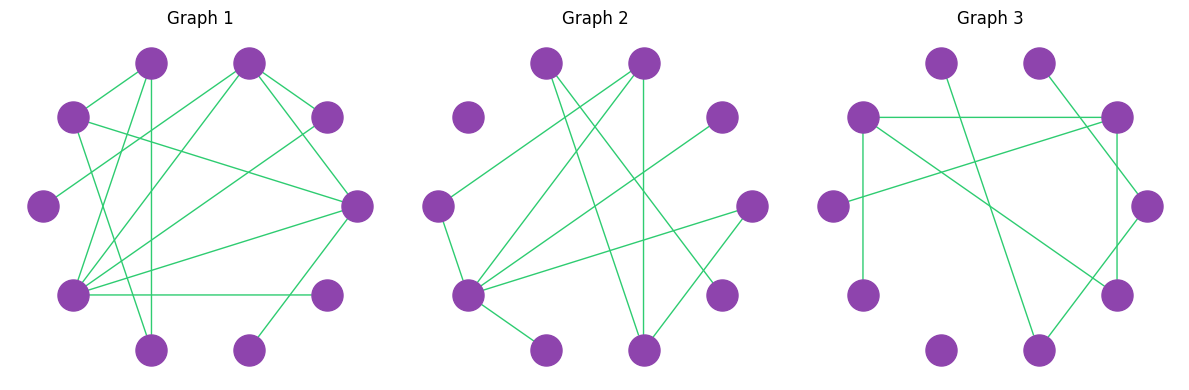

In [200]:
# Visual ER models with different realizations with parameters N, p
set_seed(4)

N, p = 10, .3

graphs = [rx.undirected_gnp_random_graph(N, p) for _ in range(3)]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (g, ax) in enumerate(zip(graphs, axes)):
    layout = rx.circular_layout(g)
    ax.set_title(f"Graph {i+1}")
    mpl_draw(g, pos=layout, ax=ax, node_color=NS_PURPLE, edge_color=NS_GREEN, with_labels=False, node_size=500)
    ax.set_axis_off()
plt.tight_layout()

## 3.3 Number of Links

The probability that a random network has exactly `L` links is the product of three terms:

* The probability that `L` of the attempts to connect the `N(N-1)/2` pairs of nodes have resulted in a link, which is ${p}^L$.
* The probability that the remaining `N(N-1)/2 - L` attempts have not resulted in a link, which is $(1-p)^{N(N-1)/2-L}$.
* A combinational factor $$
\binom{\frac{N(N-1)}{2}}{L}
$$
counting the number of different ways we can place `L` links among `N(N-1)/2` node pairs

We can therefore write the probability that a particular realization of a
random network has exactly $L$ links as

$$
p_L =
\binom{\frac{N(N-1)}{2}}{L}
\, p^L (1 - p)^{\frac{N(N-1)}{2} - L}
\tag{3.1}
$$


In [163]:
# the probability that a particular realization of a random network has exactly L links

N, p = 10, 0.1
L = 5

n_possible_edges = math.comb(N, 2)
n_possible_L = math.comb(n_possible_edges, L)

p_L = np.power(p, L)
p_not_L = np.power(1-p, n_possible_edges - L)

# prob of exactly L links
pl = n_possible_L * (p_L * p_not_L)
print(pl)

0.1805867676164421


In [164]:
def prob_l_in_random_network(N, p, L):
    n_possible_edges = math.comb(N, 2)
    n_possible_L = math.comb(n_possible_edges, L)
    
    p_L = np.power(p, L)
    p_not_L = np.power(1-p, n_possible_edges - L)
    
    pl = n_possible_L * (p_L * p_not_L)
    return pl

In [165]:
prob_l_in_random_network(10, 0.1, 5)

np.float64(0.1805867676164421)

#### The expected number of links in a random graph is given by
$$
\langle L \rangle
= \sum_{L=0}^{\frac{N(N-1)}{2}} L \, p_L
= p \, \frac{N(N-1)}{2}
$$

In [229]:
# binomial expectation of links
N, p = 10, .1

n_possible_edges = math.comb(N, 2) # N(N-1)/2
expected_edges = p*n_possible_edges # p * N(N-1)/2

print(f"Using the binomail distribution, the expected number of links: {expected_edges}")

Using the binomail distribution, the expected number of links: 4.5


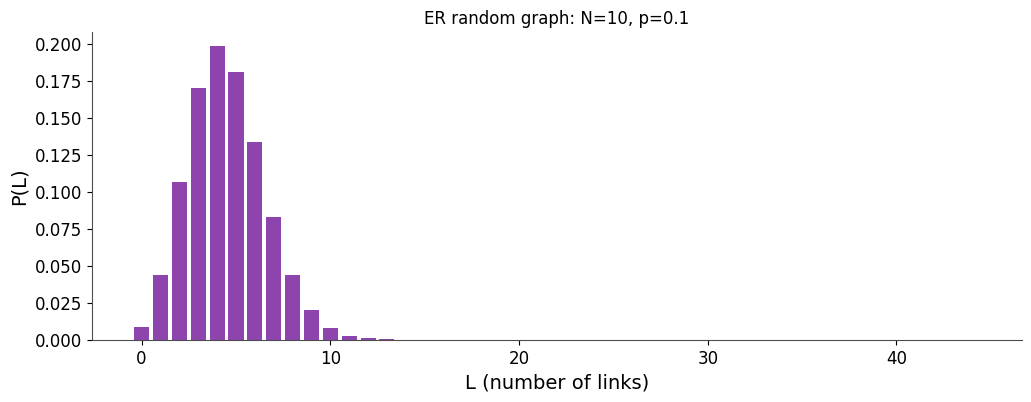

In [219]:
N, p = 10, .1

n_possible_edges = math.comb(N, 2)
Ls = list(range(n_possible_edges))

dist = [prob_l_in_random_network(N, p, l) for l in Ls]

pmf = np.array(dist)

plt.figure(figsize=(12,4))
plt.bar(Ls, pmf, color=NS_PURPLE)
plt.xlabel("L (number of links)")
plt.ylabel("P(L)")
plt.title(f"ER random graph: N={N}, p={p}")
plt.show()

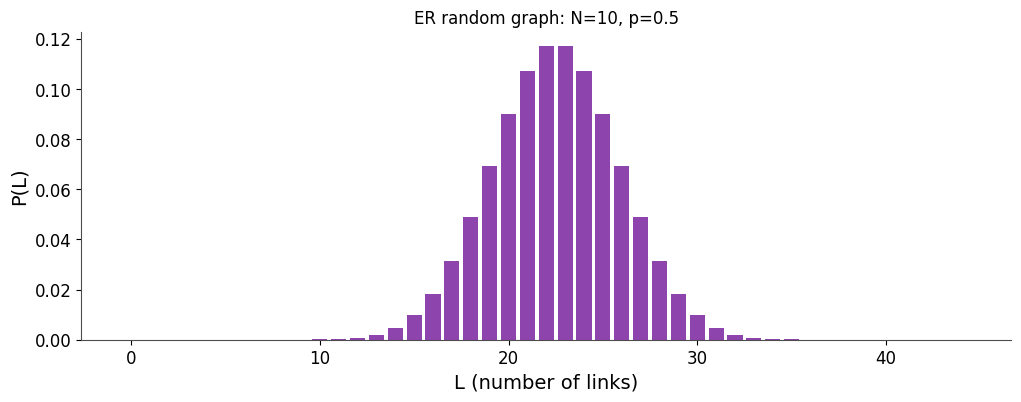

In [205]:
N, p = 10, .5

n_possible_edges = math.comb(N, 2)
Ls = list(range(n_possible_edges))

dist = [prob_l_in_random_network(N, p, l) for l in Ls]

pmf = np.array(dist)

plt.figure(figsize=(12,4))
plt.bar(Ls, pmf, color=NS_PURPLE)
plt.xlabel("L (number of links)")
plt.ylabel("P(L)")
plt.title(f"ER random graph: N={N}, p={p}")
plt.show()

In [206]:
# expected number of links is where p is the greatest
idx = np.argmax(dist)
idxs = [idx-1, idx, idx+1]
ps = pmf[idxs]
print(f"Emperically, the number of links with the highest probability:\n {idxs}")
print(f"{ps}")

Emperically, the number of links with the highest probability:
 [np.int64(21), np.int64(22), np.int64(23)]
[0.10725375 0.11700409 0.11700409]


#### The average degree of a random network is given by
$$
\langle k \rangle
= \frac{2 \langle L \rangle}{N}
= p (N - 1)
$$

In [230]:
N, p = 10, .25

n_possible_edges = math.comb(N, 2) # N(N-1)/2
expected_links = p*n_possible_links # p * N(N-1)/2

# 2*expected_links / N
# p(N-1)
assert p*(N-1) == 2*expected_links / N

# 3.4 Degree Distribution
In a given realization of a random network some nodes gain numerous links, while others acquire only a few or no links. These differences are captured by the degree distribution, ${p_k}$, which is the probability that a randomly chosen node has degree ${k}$. In this section we derive ${p_k}$ for a random network and discuss its properties.

## 3.4.1 Binomial Distribution
The degree distribution of a random network follows the binomial distribution
$$
p_k = \binom{N-1}{k} p^k (1 - p)^{N-1-k}
$$

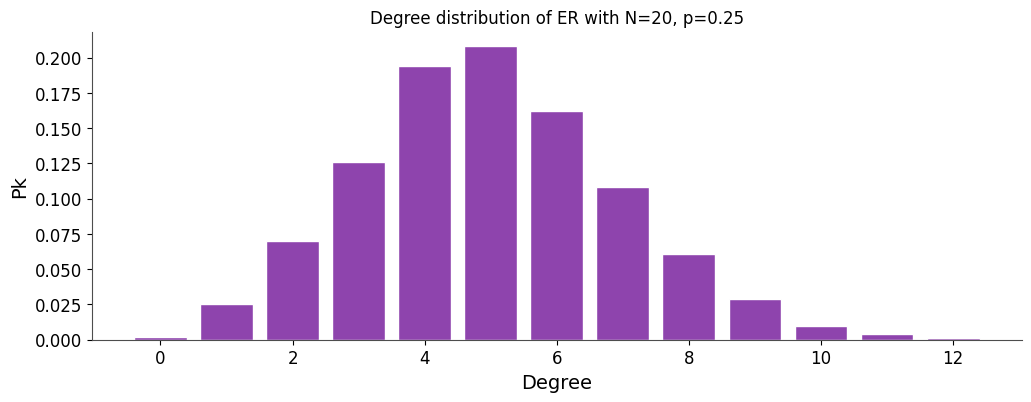

In [246]:
N, p = 20, .25

# simulates the number of edges in 1000 ER graphs
sample = np.random.binomial(N, p, 1000)
vals, counts = np.unique(sample, return_counts=True)
pk = counts / counts.sum()

plt.figure(figsize=(12,4))
plt.bar(vals, pk, color=NS_PURPLE, edgecolor='white')
plt.ylabel("Pk")
plt.xlabel("Degree")
plt.title(f"Degree distribution of ER with N={N}, p={p}")
plt.show()

## 3.4.2 Poisson Distribution
Most real networks are sparse, meaning that for them ${\langle k \rangle} << N$. In this limit the degree distribution is well approximated by the Poisson distribution 
$$
p_k =  e^{-\langle k \rangle} \frac{\langle k \rangle^{k}}{k!}
$$

##### Review Poisson basics

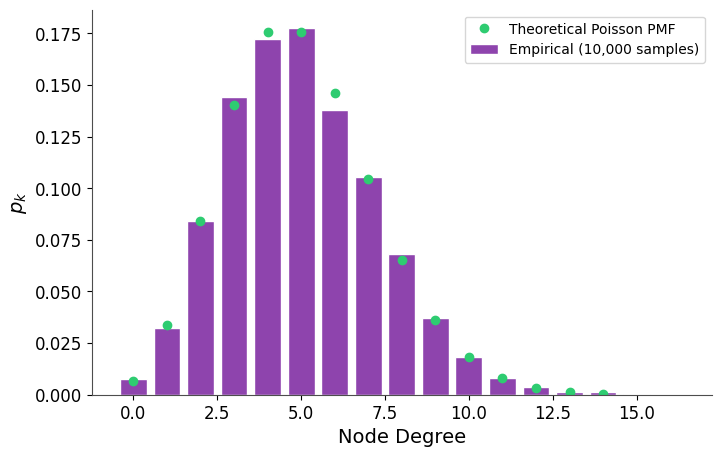

In [375]:
"""
A sample of 10,000 node degrees from the theoretical degree distribution 
of an random graph graph whose expected degree is 5 and <k> << N
"""
set_seed(11)
average_degree = 5
node_degrees = np.random.poisson(average_degree, 10000)

# empirical simulation
values, counts = np.unique(node_degrees, return_counts=True)
emp_p = counts / counts.sum()

ks = np.arange(0, 15)
pmf = np.array([poisson.pmf(k, average_degree) for k in ks])

plt.figure(figsize=(8, 5))
plt.bar(values, emp_p, color=NS_PURPLE, edgecolor="white", label="Empirical (10,000 samples)")
plt.plot(k, pmf, color=NS_GREEN, marker="o", linestyle="none", label="Theoretical Poisson PMF")
plt.xlabel("Node Degree")
plt.ylabel(r"$p_k$")
plt.legend()
plt.show()

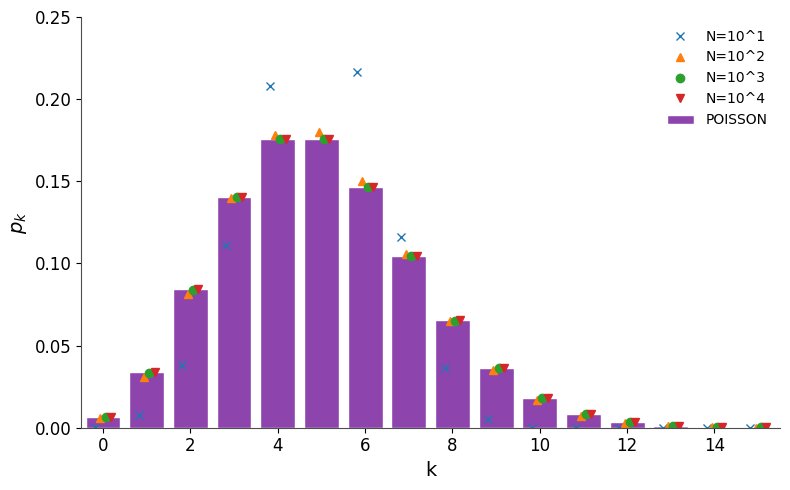

In [376]:
avg_degree = 5
Ns = [10**i for i in range(1, 5)]  # 10, 100, 1000, 10000
ks = np.arange(0, 26)

pk_poisson = poisson.pmf(ks, mu=avg_degree)

plt.figure(figsize=(8, 5))
plt.bar(ks, pk_poisson, label="POISSON", color=NS_PURPLE, edgecolor="white")

markers = ["x", "^", "o", "v"]
# small fixed offsets so points don't overlap (deterministic "jitter")
offsets = np.linspace(-0.18, 0.18, num=len(Ns))

for (N, m, dx) in zip(Ns, markers, offsets):
    # for any node in a graph there are N-1 other nodes (not N)
    n = N - 1
    # recover the p from given <k> and n
    p = avg_degree / n
    pk_binom = binom.pmf(ks, n=n, p=p)

    plt.plot(
        ks + dx, pk_binom,
        linestyle="none", marker=m, markersize=6,
        label=f"N=10^{int(np.log10(N))}"
    )

plt.xlabel("k")
plt.ylabel(r"$p_k$")
plt.ylim(0, 0.25)
plt.xlim(-0.5, 15.5)
plt.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()

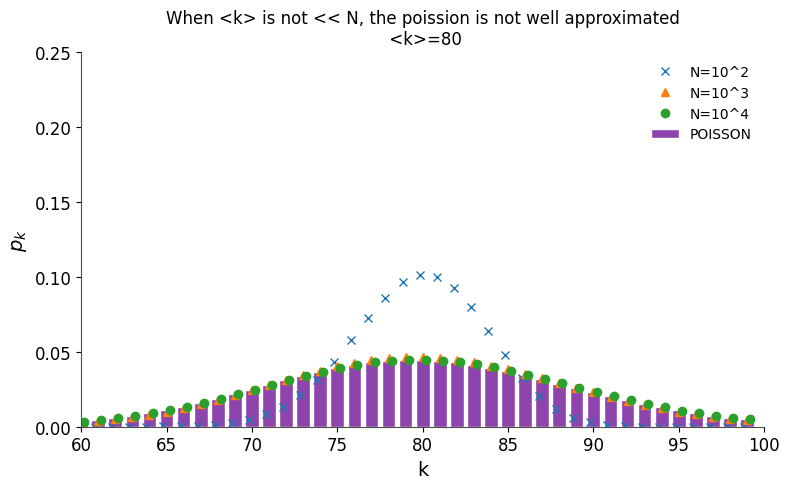

In [374]:
avg_degree = 80
Ns = [10**i for i in range(2, 5)]  # 10, 100, 1000, 10000
ks = np.arange(40, 100)

pk_poisson = poisson.pmf(ks, mu=avg_degree)

plt.figure(figsize=(8, 5))
plt.bar(ks, pk_poisson, label="POISSON", color=NS_PURPLE, edgecolor="white")

markers = ["x", "^", "o", "v"]
# small fixed offsets so points don't overlap (deterministic "jitter")
offsets = np.linspace(-0.18, 0.18, num=len(Ns))

for (N, m, dx) in zip(Ns, markers, offsets):
    # for any node in a graph there are N-1 other nodes (not N)
    n = N - 1
    # recover the p from given <k> and n
    p = avg_degree / n
    pk_binom = binom.pmf(ks, n=n, p=p)

    plt.plot(
        ks + dx, pk_binom,
        linestyle="none", marker=m, markersize=6,
        label=f"N=10^{int(np.log10(N))}"
    )

plt.title("When <k> is not << N, the poission is not well approximated\n <k>=80")
plt.xlabel("k")
plt.ylabel(r"$p_k$")
plt.ylim(0, 0.25)
plt.xlim(60, 100)
plt.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()